# Install Dependencies and Fetch Dataset

In [163]:
random_state = 1
from pprint import pprint

In [164]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
concrete_compressive_strength = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets

# metadata
pprint(concrete_compressive_strength.metadata)

# variable information
pprint(concrete_compressive_strength.variables)

{'abstract': 'Concrete is the most important material in civil engineering. '
             'The concrete compressive strength is a highly nonlinear function '
             'of age and ingredients. ',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'Number of instances \t1030\r\n'
                                'Number of Attributes\t9\r\n'
                                'Attribute breakdown\t8 quantitative input '
                                'variables, and 1 quantitative output '
                                'variable\r\n'
                                'Missing Attribute Values\tNone \r\n',
                     'variable_info': 'Given are the variable name, variable '
     

## Data Preparation

In [165]:
# test and train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Exploratory Data Analysis (EDA)

## Data Inspection

In [166]:
import pandas as pd
# Display the first few rows of the features and target
display(X_train.head())
display(y_train.head())
display(X_test.head())
display(y_test.head())

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
612,277.0,0.0,0.0,191.0,0.0,968.0,856.0,28
525,359.0,19.0,141.0,154.0,10.9,942.0,801.0,3
597,272.8,181.9,0.0,185.7,0.0,1012.4,714.3,28
846,366.0,187.0,0.0,191.0,7.0,824.0,757.0,28
259,212.6,0.0,100.4,159.4,10.4,1003.8,903.8,3


,Concrete compressive strength
612,25.97
525,25.12
597,31.38
846,65.91
259,13.33


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
339,297.2,0.0,117.5,174.8,9.5,1022.8,753.5,3
244,238.1,0.0,94.1,186.7,7.0,949.9,847.0,3
882,140.0,133.0,103.0,200.0,7.0,916.0,753.0,28
567,203.5,135.7,0.0,185.7,0.0,1076.2,759.3,7
923,162.0,207.0,172.0,216.0,10.0,822.0,638.0,28


,Concrete compressive strength
339,21.91
244,19.93
882,36.44
567,11.96
923,39.84


In [167]:
# Display the shape of the features and target
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (824, 8)
Shape of y_train: (824, 1)
Shape of X_test: (206, 8)
Shape of y_test: (206, 1)


In [168]:
# Display the data types of the features and target
print("Data types of features (X):")
print(X_train.dtypes)
print("\nData types of target (y):")
print(y_train.dtypes)

Data types of features (X):
Cement                float64
Blast Furnace Slag    float64
Fly Ash               float64
Water                 float64
Superplasticizer      float64
Coarse Aggregate      float64
Fine Aggregate        float64
Age                     int64
dtype: object

Data types of target (y):
Concrete compressive strength    float64
dtype: object


## Check for Missing Values

In [169]:
missing_values_X = X.isnull().sum()
missing_values_y = y.isnull().sum()
print("Missing values in features (X):")
print(missing_values_X)
print("\nMissing values in target (y):")
print(missing_values_y)

Missing values in features (X):
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
dtype: int64

Missing values in target (y):
Concrete compressive strength    0
dtype: int64


## Summary Statistics

In [170]:
summary_X_train = X_train.describe()
print("Summary statistics for features (X_train):")
print(summary_X_train)

Summary statistics for features (X_train):
           Cement  Blast Furnace Slag     Fly Ash       Water  \
count  824.000000          824.000000  824.000000  824.000000   
mean   279.569053           71.445631   54.552670  181.516869   
std    104.483317           85.417432   64.271947   20.955400   
min    102.000000            0.000000    0.000000  121.800000   
25%    191.675000            0.000000    0.000000  164.900000   
50%    266.000000           19.500000    0.000000  185.000000   
75%    350.000000          142.500000  118.300000  192.000000   
max    540.000000          359.400000  200.100000  247.000000   

       Superplasticizer  Coarse Aggregate  Fine Aggregate         Age  
count        824.000000        824.000000      824.000000  824.000000  
mean           6.012257        973.564199      776.894782   44.609223  
std            5.792116         77.349064       78.344553   60.584698  
min            0.000000        801.000000      594.000000    1.000000  
25%        

In [171]:
summary_y_train = y_train.describe()
print("\nSummary statistics for target (y_train):")
print(summary_y_train)


Summary statistics for target (y_train):
       Concrete compressive strength
count                     824.000000
mean                       35.407828
std                        16.817911
min                         2.330000
25%                        23.047500
50%                        33.745000
75%                        45.370000
max                        81.750000


## Visualizations

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

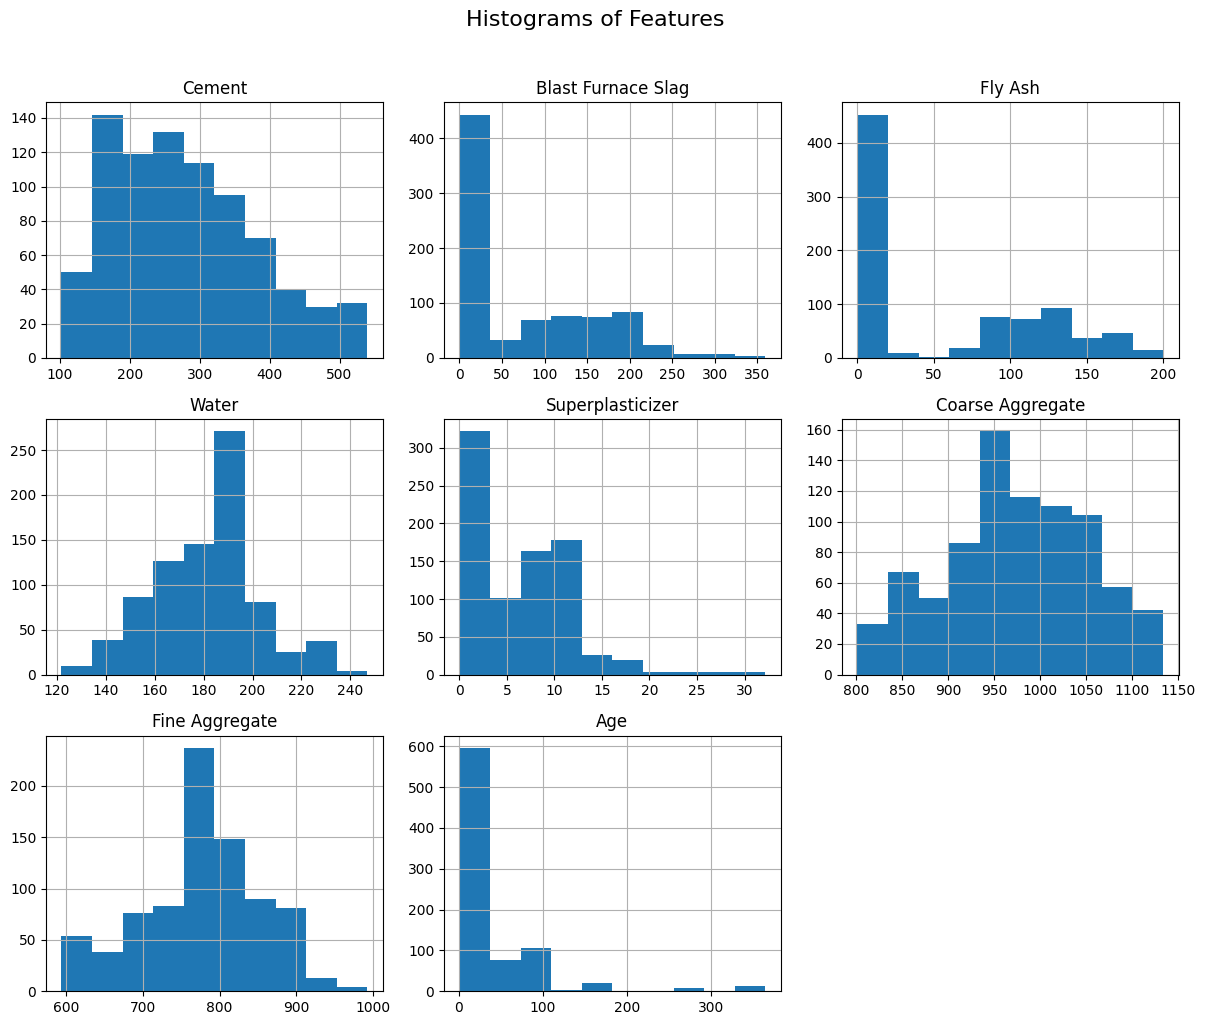

In [173]:
# Histograms for each feature
X_train.hist(figsize=(12, 10))
plt.suptitle("Histograms of Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

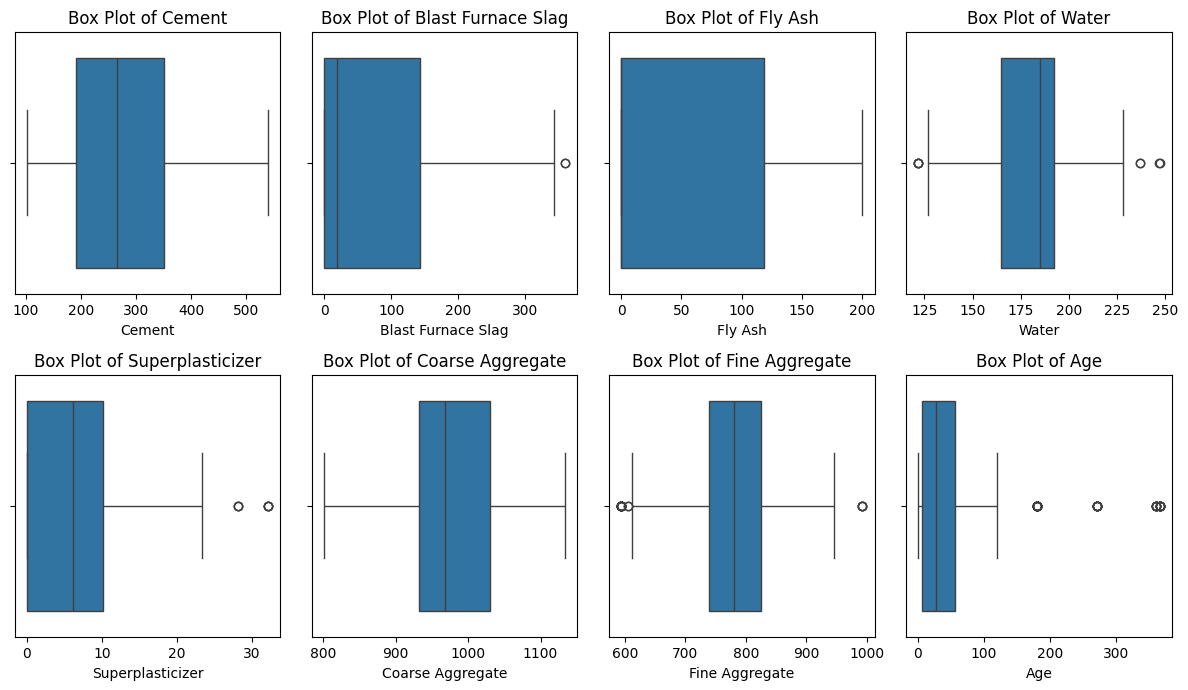

In [174]:
# Box plots for each feature
plt.figure(figsize=(12, 10))
for i, column in enumerate(X_train.columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=X_train[column])
    plt.title(f"Box Plot of {column}")
plt.tight_layout()
plt.show()

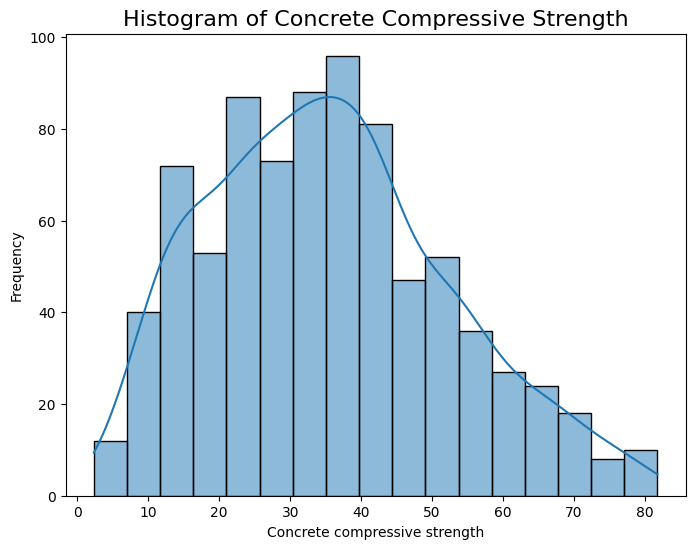

In [175]:
# Histogram of Concrete Compressive Strength
plt.figure(figsize=(8, 6))
sns.histplot(y_train["Concrete compressive strength"], kde=True)
plt.title("Histogram of Concrete Compressive Strength", fontsize=16)
plt.xlabel("Concrete compressive strength")
plt.ylabel("Frequency")
plt.show()

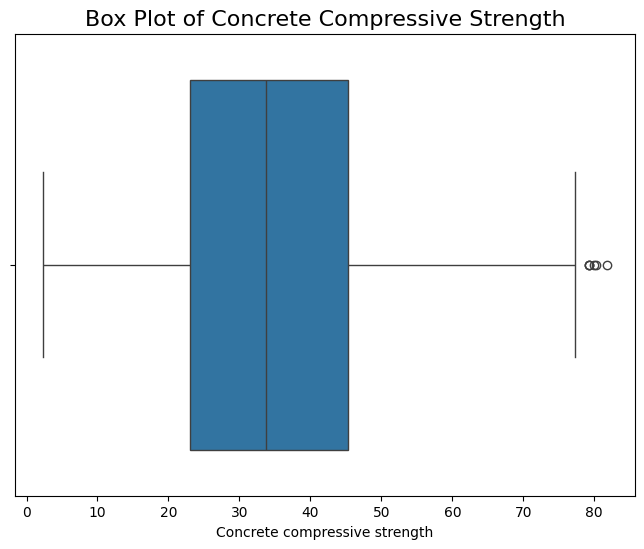

In [176]:
# Box Plot of Concrete Compressive Strength
plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train["Concrete compressive strength"])
plt.title("Box Plot of Concrete Compressive Strength", fontsize=16)
plt.xlabel("Concrete compressive strength")
plt.show()

## Correlation Analysis

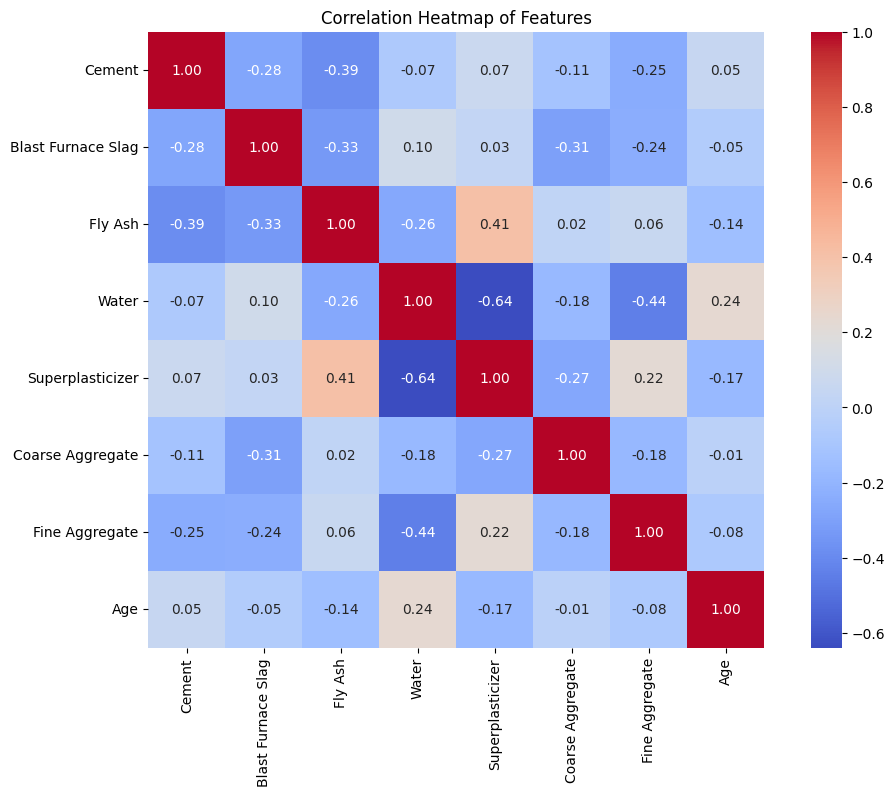

In [177]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Features')
plt.show()

# Bayesian Optimization

## Objective Function

The goal is to optimize the concrete compressive strength using Bayesian optimization. The objective function will be defined to minimize the negative of the compressive strength, as we want to maximize it. The parameters to be optimized will include the features of the concrete mix.

In [178]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor

In [179]:
# Define the model
model = RandomForestRegressor(random_state=random_state)

In [180]:
# Define the search space for hyperparameters
search_space = {
    'n_estimators': (50, 500),  # Number of trees in the forest
    'max_depth': (5, 50),        # Maximum depth of the tree
    'min_samples_split': (2, 20), # Minimum number of samples required to split an internal node
    'min_samples_leaf': (1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

In [181]:
# Define the Bayesian optimization search
opt = BayesSearchCV(
    model,
    search_space,
    n_iter=50,  # Number of iterations for optimization
    scoring='neg_mean_squared_error',  # Objective function to minimize
    cv=5,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    random_state=random_state
)

In [182]:
# Fit the model using Bayesian optimization
opt.fit(X_train, y_train.values.ravel())

C:\Users\adurs\OneDrive\Documents\repos\WashU\Assistantship\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(50), np.str_('log2'), np.int64(1), np.int64(2), np.int64(500)] before, using random point [True, np.int64(36), 'sqrt', np.int64(12), np.int64(5), np.int64(170)]
  warnings.warn(
C:\Users\adurs\OneDrive\Documents\repos\WashU\Assistantship\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(50), np.str_('log2'), np.int64(1), np.int64(3), np.int64(500)] before, using random point [True, np.int64(33), None, np.int64(16), np.int64(18), np.int64(447)]
  warnings.warn(
C:\Users\adurs\OneDrive\Documents\repos\WashU\Assistantship\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.False_, np.int64(50), np.str_('log2'), np.int64(1), np.int64(3), np.int64(500)] 

BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
              random_state=1, scoring='neg_mean_squared_error',
              search_spaces={'bootstrap': [True, False], 'max_depth': (5, 50),
                             'max_features': ['sqrt', 'log2', None],
                             'min_samples_leaf': (1, 20),
                             'min_samples_split': (2, 20),
                             'n_estimators': (50, 500)})

In [183]:
# Display the best parameters found by Bayesian optimization
print("Best parameters found by Bayesian optimization:")
pprint(opt.best_params_)

Best parameters found by Bayesian optimization:
OrderedDict([('bootstrap', False),
             ('max_depth', 50),
             ('max_features', 'log2'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 3),
             ('n_estimators', 500)])


In [184]:
# Display the best score achieved
print(f"Best score achieved (negative MSE): {opt.best_score_}")

Best score achieved (negative MSE): -26.180173893043104


In [185]:
# Evaluate the optimized model on the test set
from sklearn.metrics import mean_squared_error
y_pred = opt.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 25.08182140012043


## Use Optimized Model to Optimize Concrete Mix using Bayesian Optimization

In [186]:
# Use the optimized model to predict concrete compressive strength
optimized_strength = opt.predict(X_test)
print("Predicted Concrete Compressive Strength using Optimized Model:")
print(optimized_strength)

Predicted Concrete Compressive Strength using Optimized Model:
[24.85285 14.82067 34.3176  10.99681 28.38785 66.87017 21.20943 50.57759
 39.24931 18.98809 33.57128 13.46    40.31233 31.83627 12.0023  26.8664
 37.6958  54.05839 57.84378 38.6063  25.1981  51.66731 16.48828 59.74149
 64.08807 44.61728 34.43666 32.4703  35.70648 13.09724 41.84826 49.82064
 22.57267 25.6921  33.96241 36.38608 15.66403 24.3564  25.8156  16.12241
 42.89221 15.71307 45.80504 36.84871 34.007   26.33104 31.77389 27.94673
 35.68057 49.45782 25.24924 37.13169 62.61673 53.64965 57.96     9.95151
 37.26337 25.00099 34.72358 45.72544 49.55991 43.30181 51.25052 53.80437
 23.81796 33.95116 56.78534 36.59803 44.96739 26.06048 37.11921 26.15649
 36.46248 10.62161 73.36785 61.6717  48.73079 16.62789 57.54296 51.8703
 33.48402 47.12474 52.00105 38.56343 44.81366 50.38052 32.42057 55.43148
 51.9725  56.43882 36.27105 31.27335 30.20359 41.80773 33.98098 71.71199
 39.36652 13.46148 31.257   29.58172 35.9711  58.16    36.17427

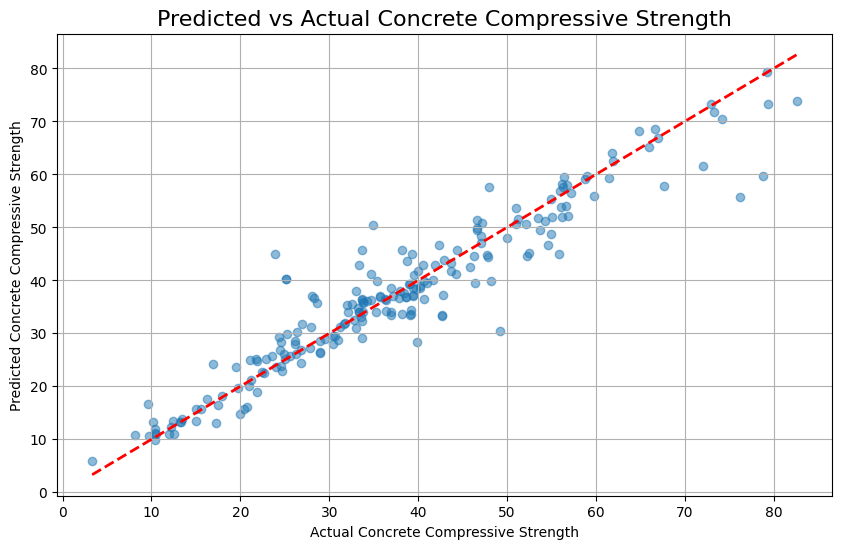

In [187]:
# Visualize the predicted vs actual concrete compressive strength
plt.figure(figsize=(10, 6))
plt.scatter(y_test, optimized_strength, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Concrete Compressive Strength', fontsize=16)
plt.xlabel('Actual Concrete Compressive Strength')
plt.ylabel('Predicted Concrete Compressive Strength')
plt.grid()
plt.show()

In [ ]:
# First check the actual column names in the DataFrame
print("Actual column names in X_train:")
print(X_train.columns.tolist())

In [188]:
# Objective function for Bayesian optimization
def objective_function(params):
    """
    Objective function to minimize the negative of the compressive strength.
    This function takes a the parameters of the concrete mix and returns the negative compressive strength.
    """
    # Unpack the parameters
    cement, slag, ash, water, superplasticizer, coarse_aggregate, fine_aggregate, age = params
    # Create a DataFrame with the parameters
    concrete_mix = pd.DataFrame({
        'Cement': [cement],
        'Blast Furnace Slag': [slag],
        'Fly Ash': [ash],
        'Water': [water],
        'Superplasticizer': [superplasticizer],
        'Coarse Aggregate': [coarse_aggregate],
        'Fine Aggregate': [fine_aggregate],
        'Age': [age]
    })
    # Predict the compressive strength using the optimized model
    predicted_strength = opt.predict(concrete_mix)
    # Return the negative compressive strength (as we want to maximize it)
    return -predicted_strength[0]

In [189]:
# Define the search space for the parameters of the concrete mix based on the min and max values in the training set
search_space_concrete = [
    (X_train['Cement'].min(), X_train['Cement'].max()),  # Cement
    (X_train['Blast Furnace Slag'].min(), X_train['Blast Furnace Slag'].max()),  # Slag
    (X_train['Fly Ash'].min(), X_train['Fly Ash'].max()),  # Ash
    (X_train['Water'].min(), X_train['Water'].max()),  # Water
    (X_train['Superplasticizer'].min(), X_train['Superplasticizer'].max()),  # Superplasticizer
    (X_train['Coarse Aggregate'].min(), X_train['Coarse Aggregate'].max()),  # Coarse Aggregate
    (X_train['Fine Aggregate'].min(), X_train['Fine Aggregate'].max()),  # Fine Aggregate
    (X_train['Age'].min(), X_train['Age'].max())  # Age
]

Actual column names in X_train:
['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']


In [190]:
from skopt import gp_minimize
# Perform Bayesian optimization to find the optimal concrete mix parameters
result = gp_minimize(
    objective_function,
    search_space_concrete,
    n_calls=50,  # Number of evaluations
    random_state=random_state,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0698
Function value obtained: -59.1263
Current minimum: -59.1263
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0670
Function value obtained: -66.1417
Current minimum: -66.1417
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0547
Function value obtained: -46.5477
Current minimum: -66.1417
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0743
Function value obtained: -61.0239
Current minimum: -66.1417
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0549
Function value obtained: -63.1562
Current minimum: -66.1417
Iteration No: 6

In [191]:
# Neatly display the best parameters and the best predicted compressive strength along with column names
best_params = result.x
best_strength = -result.fun  # Negate the result to get the actual strength
print("Best parameters found by Bayesian optimization:")
for i, param in enumerate(best_params):
    print(f"{X_train.columns[i]}: {param}")
print(f"Best predicted Concrete Compressive Strength: {best_strength}")

Best parameters found by Bayesian optimization:
Cement: 529.6665391696931
Blast Furnace Slag: 253.31560267417578
Fly Ash: 0.0
Water: 185.32729299183944
Superplasticizer: 28.29873111507148
Coarse Aggregate: 801.0
Fine Aggregate: 675.3108825846068
Age: 343
Best predicted Concrete Compressive Strength: 68.83961000000016


## Use XGBoost for the Model instead of Random Forest

In [192]:
from xgboost import XGBRegressor

In [193]:
# Define the XGBoost model
xgb_model = XGBRegressor(random_state=random_state, n_jobs=-1)

In [194]:
# Define the Bayesian optimization search for XGBoost hyperparameters
xgb_search_space = {
    'n_estimators': (50, 500),  # Number of trees in the forest
    'max_depth': (3, 10),        # Maximum depth of the tree
    'learning_rate': (0.01, 0.3, 'uniform'),  # Step size shrinkage used in update to prevent overfitting
    'subsample': (0.5, 1.0, 'uniform'),  # Subsample ratio of the training instances
    'colsample_bytree': (0.5, 1.0, 'uniform'),  # Subsample ratio of columns when constructing each tree
    'gamma': (0, 5),  # Minimum loss reduction required to make a further partition on a leaf
    'reg_alpha': (0, 1),  # L1 regularization term on weights
    'reg_lambda': (0, 1)  # L2 regularization term on weights
}

In [195]:
# Define the Bayesian optimization search for XGBoost
xgb_opt = BayesSearchCV(
    xgb_model,
    xgb_search_space,
    n_iter=50,  # Number of iterations for optimization
    scoring='neg_mean_squared_error',  # Objective function to minimize
    cv=5,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    random_state=random_state
)

In [197]:
# Fit the XGBoost model using Bayesian optimization
xgb_opt.fit(X_train, y_train.values.ravel())

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=1, scoring='neg_mean_squared_error',
              search_spaces={'colsample_bytree': (0.5, 1.0, 'uniform'),
                             'gamma': (0, 5),
                             'learning_rate': (0.01, 0.3, 'uniform'),
                             'max_depth': (3, 10), 'n_estimators': (50, 500),
                             'reg_alpha': (0, 1), 'reg_lambda': (0, 1),
                             'subsample': (0.5, 1.0, 'uniform')})

In [198]:
# Display the best parameters found by Bayesian optimization for XGBoost
print("Best parameters found by Bayesian optimization for XGBoost:")
pprint(xgb_opt.best_params_)

Best parameters found by Bayesian optimization for XGBoost:
OrderedDict([('colsample_bytree', 0.8066487829601411),
             ('gamma', 0),
             ('learning_rate', 0.3),
             ('max_depth', 3),
             ('n_estimators', 500),
             ('reg_alpha', 1),
             ('reg_lambda', 1),
             ('subsample', 1.0)])


In [199]:
# Display the best score achieved by XGBoost
print(f"Best score achieved (negative MSE) by XGBoost: {xgb_opt.best_score_}")

Best score achieved (negative MSE) by XGBoost: -17.317474228401203


In [200]:
# Evaluate the optimized XGBoost model on the test set
y_pred_xgb = xgb_opt.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"Mean Squared Error on test set by XGBoost: {mse_xgb}")

Mean Squared Error on test set by XGBoost: 22.36115264892578


In [201]:
# Use the optimized XGBoost model to predict concrete compressive strength
optimized_strength_xgb = xgb_opt.predict(X_test)
print("Predicted Concrete Compressive Strength using Optimized XGBoost Model:")
print(optimized_strength_xgb)

Predicted Concrete Compressive Strength using Optimized XGBoost Model:
[26.082323  12.637122  32.867004  15.318484  30.714983  71.82758
 18.72487   52.325623  39.23202   21.070223  36.049603  14.309813
 35.005047  31.596542  10.207006  26.924625  36.794327  58.432102
 60.571186  39.06563   19.156292  50.44783   18.531397  64.22511
 61.095074  46.21929   37.732124  31.29467   38.03248   12.909925
 42.42308   57.219437  26.816568  30.173649  32.971516  34.60836
 19.912148  26.399454  23.889095  17.36606   38.016163  14.598394
 48.432026  38.903633  36.174522  26.452765  32.820847  32.730392
 35.19271   47.744057  25.280655  35.507954  63.84186   52.43774
 55.53031    9.410225  38.457447  23.624197  31.520657  44.098866
 51.22605   43.75679   53.51431   53.918976  21.289402  34.72049
 54.151596  37.326206  38.83065   24.893694  23.295012  26.673162
 34.526413  11.19537   72.91485   63.59068   54.725708  15.417551
 63.368916  48.6498    42.586395  46.07942   54.632553  31.70571
 47.48668  

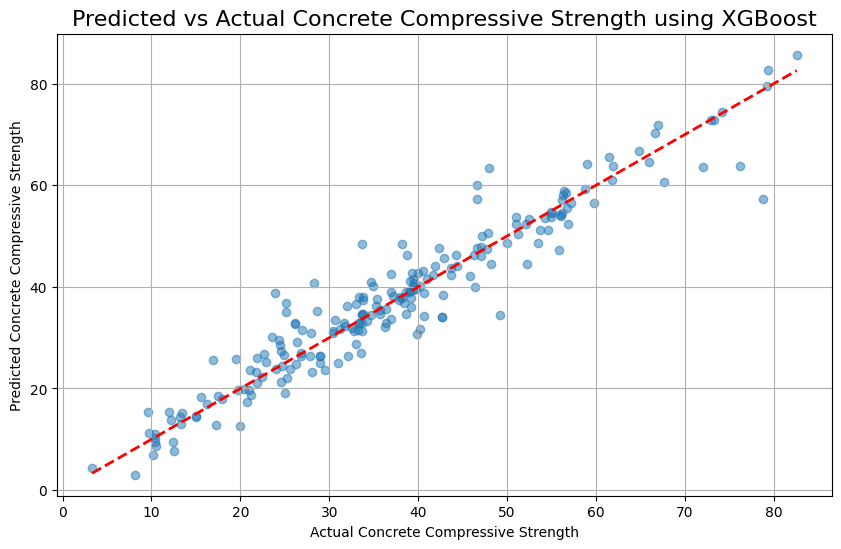

In [202]:
# Visualize the predicted vs actual concrete compressive strength using XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, optimized_strength_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Concrete Compressive Strength using XGBoost', fontsize=16)
plt.xlabel('Actual Concrete Compressive Strength')
plt.ylabel('Predicted Concrete Compressive Strength')
plt.grid()
plt.show()

In [203]:
# Objective function for Bayesian optimization with XGBoost
def objective_function_xgb(params):
    """
    Objective function to minimize the negative of the compressive strength using XGBoost.
    This function takes the parameters of the concrete mix and returns the negative compressive strength.
    """
    # Unpack the parameters
    cement, slag, ash, water, superplasticizer, coarse_aggregate, fine_aggregate, age = params
    # Create a DataFrame with the parameters
    concrete_mix = pd.DataFrame({
        'Cement': [cement],
        'Blast Furnace Slag': [slag],
        'Fly Ash': [ash],
        'Water': [water],
        'Superplasticizer': [superplasticizer],
        'Coarse Aggregate': [coarse_aggregate],
        'Fine Aggregate': [fine_aggregate],
        'Age': [age]
    })
    # Predict the compressive strength using the optimized XGBoost model
    predicted_strength = xgb_opt.predict(concrete_mix)
    # Return the negative compressive strength (as we want to maximize it)
    return -predicted_strength[0]

In [204]:
# Define the search space for the parameters of the concrete mix based on the min and max values in the training set
search_space_concrete_xgb = [
    (X_train['Cement'].min(), X_train['Cement'].max()),  # Cement
    (X_train['Blast Furnace Slag'].min(), X_train['Blast Furnace Slag'].max()),  # Slag
    (X_train['Fly Ash'].min(), X_train['Fly Ash'].max()),  # Ash
    (X_train['Water'].min(), X_train['Water'].max()),  # Water
    (X_train['Superplasticizer'].min(), X_train['Superplasticizer'].max()),  # Superplasticizer
    (X_train['Coarse Aggregate'].min(), X_train['Coarse Aggregate'].max()),  # Coarse Aggregate
    (X_train['Fine Aggregate'].min(), X_train['Fine Aggregate'].max()),  # Fine Aggregate
    (X_train['Age'].min(), X_train['Age'].max())  # Age
]

In [205]:
from skopt import gp_minimize
# Perform Bayesian optimization to find the optimal concrete mix parameters using XGBoost
result_xgb = gp_minimize(
    objective_function_xgb,
    search_space_concrete_xgb,
    n_calls=50,  # Number of evaluations
    random_state=random_state,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0035
Function value obtained: -67.0703
Current minimum: -67.0703
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0040
Function value obtained: -84.5888
Current minimum: -84.5888
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0035
Function value obtained: -47.0741
Current minimum: -84.5888
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0025
Function value obtained: -75.4095
Current minimum: -84.5888
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0030
Function value obtained: -54.6111
Current minimum: -84.5888
Iteration No: 6

In [206]:
# Neatly display the best parameters and the best predicted compressive strength along with column names for XGBoost
best_params_xgb = result_xgb.x
best_strength_xgb = -result_xgb.fun  # Negate the result to get the actual strength
print("Best parameters found by Bayesian optimization for XGBoost:")
for i, param in enumerate(best_params_xgb):
    print(f"{X_train.columns[i]}: {param}")
print(f"Best predicted Concrete Compressive Strength using XGBoost: {best_strength_xgb}")

Best parameters found by Bayesian optimization for XGBoost:
Cement: 540.0
Blast Furnace Slag: 300.65291287447013
Fly Ash: 0.0
Water: 158.45175453046843
Superplasticizer: 19.253256013961217
Coarse Aggregate: 989.7225107776761
Fine Aggregate: 744.9362652309543
Age: 285
Best predicted Concrete Compressive Strength using XGBoost: 97.2592544555664


# Conclusion

In this notebook, I successfully fetched the Concrete Compressive Strength dataset, performed exploratory data analysis, and applied Bayesian optimization to find the optimal concrete mix parameters using both Random Forest and XGBoost models. The results showed that we could predict the concrete compressive strength effectively, and the optimized parameters were displayed for both models. The XGBoost model provided a robust alternative to the Random Forest model, demonstrating the flexibility of using different machine learning algorithms for optimization tasks.